In [1]:
!pip install transformers datasets scikit-learn

In [2]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.manifold import TSNE
from sklearn.calibration import calibration_curve, CalibrationDisplay
import matplotlib.pyplot as plt
import numpy as np

def plot_diagnostics(y_true, y_pred, y_prob, embeddings, title_prefix=""):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axs[0], cmap='Blues', colorbar=False)
    axs[0].set_title(f"{title_prefix}Confusion Matrix")

    # t-SNE projection of embeddings
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    emb_2d = tsne.fit_transform(embeddings)
    axs[1].scatter(emb_2d[:, 0], emb_2d[:, 1], c=y_true, cmap='coolwarm', alpha=0.6, s=15)
    axs[1].set_title(f"{title_prefix}t-SNE of Embeddings")

    # Calibration curve
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10)
    disp_cal = CalibrationDisplay(prob_true, prob_pred, y_prob)
    disp_cal.plot(ax=axs[2])
    axs[2].set_title(f"{title_prefix}Calibration Curve")

    plt.tight_layout()
    plt.show()

In [3]:
import os
import numpy as np
import pandas as pd
import torch

from transformers import AutoTokenizer, AutoModel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from collections import Counter


import matplotlib.pyplot as plt



model_name = "InstaDeepAI/nucleotide-transformer-500m-1000g"
tokenizer  = AutoTokenizer.from_pretrained(model_name)
model      = AutoModel.from_pretrained(model_name)
model.eval()

import torch
from transformers import AutoTokenizer, AutoModel

model_name = "InstaDeepAI/nucleotide-transformer-500m-1000g"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/129 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/28.7k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/101 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/706 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.94G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.94G [00:00<?, ?B/s]

Some weights of EsmModel were not initialized from the model checkpoint at InstaDeepAI/nucleotide-transformer-500m-1000g and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of EsmModel were not initialized from the model checkpoint at InstaDeepAI/nucleotide-transformer-500m-1000g and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
from tqdm import tqdm  # make sure tqdm is already imported

def get_embeddings(sequences, batch_size=16):
    all_embeddings = []
    for i in tqdm(range(0, len(sequences), batch_size), desc="Embedding batches"):
        batch = sequences[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
        cls_emb = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        all_embeddings.append(cls_emb)
    return np.vstack(all_embeddings)


def classify_embeddings(X, y, n_runs=5):
    #Run StratifiedKFold LR n_runs times; return list of mean accuracies.
    results = []
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for run in range(n_runs):
        fold_acc = []
        for train_idx, test_idx in skf.split(X, y):
            clf = LogisticRegression(max_iter=1000)
            clf.fit(X[train_idx], y[train_idx])
            preds = clf.predict(X[test_idx])
            fold_acc.append(accuracy_score(y[test_idx], preds))
        results.append(np.mean(fold_acc))
    return results


# Benchmark 1: Pathogenic vs Benign


In [6]:

path1 = '/content/drive/MyDrive/genomics_project/data/benchmark_path_benign_snvs_grch37.csv'
df1 = pd.read_csv(path1)

# Filter to only Pathogenic and Benign classes
df1 = df1[df1['ClinicalSignificance'].isin(['Pathogenic', 'Benign'])]
df1 = df1.dropna(subset=['Chromosome', 'PositionVCF', 'ReferenceAlleleVCF', 'AlternateAlleleVCF'])
df1['label'] = df1['ClinicalSignificance'].map({'Pathogenic': 1, 'Benign': 0})

# Load chr1 reference genome
chr1_seq_lines = []
with open('/content/drive/MyDrive/genomics_project/data/chr1.fa', 'r') as f:
    for line in f:
        if not line.startswith(">"):
            chr1_seq_lines.append(line.strip().upper())
chr1_sequence = ''.join(chr1_seq_lines)


# Extract sequence window

In [7]:
def get_sequence_window(row, flank=100):
    try:
        chrom = str(row['Chromosome']).lower()
        if chrom not in ["1", "chr1"]:
            return None
        pos = int(row['PositionVCF']) - 1
        alt = row['AlternateAlleleVCF']
        start = max(0, pos - flank)
        end = pos + flank + 1
        context = chr1_sequence[start:end]
        if len(context) != 2 * flank + 1:
            return None
        center = flank
        context = context[:center] + alt + context[center + 1:]
        return context
    except Exception:
        return None

df1['sequence'] = df1.apply(get_sequence_window, axis=1)
df1 = df1.dropna(subset=['sequence'])

print("Usable variants with sequence context:", df1.shape[0])
df1[['sequence', 'label']].head()

Usable variants with sequence context: 21942


,sequence,label
18,TAAAAAGAAAAAAATTGAGTTTAATATTAAAAATTAAAGTTTACTT...,1
19,GCCCTCTGTAGCCTGAGATCTGCTTTTTTCTAGATCATCTTTGCTA...,1
20,CTGGCTCTATCAGAGACCTCAGGCTAGTCACCAGCTGCTTCGCATC...,1
21,GATCATCTTTGCTAAGGATGGGCATTTTGCCCTGGAGGAGCTGGCC...,1
22,GGGCTCTGGAGGGCCTCAAGGCTGAGCCCTGTCTTCCCTCTGTATG...,1


## Classify with Nucleotide Transformer (5 Runs)


In [9]:
accuracies_1, f1_scores_1, roc_aucs_1 = [], [], []
run_outputs_1 = []

for seed in range(10):
    print(f"\nSNV Pathogenicity Run {seed+1}")

    df_pos = df1[df1['label'] == 1].sample(n=1200, random_state=seed)
    df_neg = df1[df1['label'] == 0].sample(n=1200, random_state=seed)
    df_sampled = pd.concat([df_pos, df_neg]).sample(frac=1, random_state=seed)

    sequences = df_sampled['sequence'].tolist()
    labels = df_sampled['label'].tolist()

    embeddings = get_embeddings(sequences)
    X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=seed)

    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    accuracies_1.append(acc)
    f1_scores_1.append(f1)
    roc_aucs_1.append(auc)
    run_outputs_1.append((y_test, y_pred, y_prob, X_test))

    print(f"Accuracy: {acc:.4f}, F1: {f1:.4f}, ROC AUC: {auc:.4f}")


SNV Pathogenicity Run 1


Embedding batches: 100%|██████████| 150/150 [00:07<00:00, 19.77it/s]


Accuracy: 0.6125, F1: 0.6141, ROC AUC: 0.6684

SNV Pathogenicity Run 2


Embedding batches: 100%|██████████| 150/150 [00:07<00:00, 19.45it/s]


Accuracy: 0.6396, F1: 0.6505, ROC AUC: 0.7028

SNV Pathogenicity Run 3


Embedding batches: 100%|██████████| 150/150 [00:07<00:00, 19.04it/s]


Accuracy: 0.6062, F1: 0.6166, ROC AUC: 0.6491

SNV Pathogenicity Run 4


Embedding batches: 100%|██████████| 150/150 [00:07<00:00, 19.21it/s]


Accuracy: 0.5896, F1: 0.5745, ROC AUC: 0.6642

SNV Pathogenicity Run 5


Embedding batches: 100%|██████████| 150/150 [00:07<00:00, 19.07it/s]


Accuracy: 0.6083, F1: 0.6357, ROC AUC: 0.6795

SNV Pathogenicity Run 6


Embedding batches: 100%|██████████| 150/150 [00:07<00:00, 19.21it/s]


Accuracy: 0.6146, F1: 0.6278, ROC AUC: 0.6497

SNV Pathogenicity Run 7


Embedding batches: 100%|██████████| 150/150 [00:07<00:00, 18.97it/s]


Accuracy: 0.6667, F1: 0.6838, ROC AUC: 0.6946

SNV Pathogenicity Run 8


Embedding batches: 100%|██████████| 150/150 [00:07<00:00, 18.99it/s]


Accuracy: 0.5917, F1: 0.5882, ROC AUC: 0.6300

SNV Pathogenicity Run 9


Embedding batches: 100%|██████████| 150/150 [00:07<00:00, 18.85it/s]


Accuracy: 0.6562, F1: 0.6526, ROC AUC: 0.7037

SNV Pathogenicity Run 10


Embedding batches: 100%|██████████| 150/150 [00:08<00:00, 18.68it/s]


Accuracy: 0.6104, F1: 0.6207, ROC AUC: 0.6411


# Benchmark 3: Shuffled vs Real DNA Sequences


In [15]:
import random

accuracies_2, f1_scores_2, roc_aucs_2 = [], [], []
run_outputs_2 = []

for seed in range(10):
    print(f"\n-- Run {seed+1} --")
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    real_seqs = real_sequences[:100]
    shuffled_seqs = [shuffle_dna(seq) for seq in real_seqs]
    X = real_seqs + shuffled_seqs
    y = [1]*100 + [0]*100

    embeddings = get_embeddings(X)

    X_train, X_test, y_train, y_test = train_test_split(embeddings, y, test_size=0.2, random_state=seed)

    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    accuracies_2.append(acc)
    f1_scores_2.append(f1)
    roc_aucs_2.append(auc)
    run_outputs_2.append((y_test, y_pred, y_prob, X_test))

    print(f"Accuracy: {acc:.4f}, F1 Score: {f1:.4f}, ROC AUC: {auc:.4f}")


-- Run 1 --


Embedding batches: 100%|██████████| 13/13 [00:02<00:00,  4.98it/s]


Accuracy: 0.7500, F1 Score: 0.6429, ROC AUC: 0.7500

-- Run 2 --


Embedding batches: 100%|██████████| 13/13 [00:02<00:00,  5.25it/s]


Accuracy: 0.7000, F1 Score: 0.6667, ROC AUC: 0.8159

-- Run 3 --


Embedding batches: 100%|██████████| 13/13 [00:02<00:00,  5.31it/s]


Accuracy: 0.7250, F1 Score: 0.7179, ROC AUC: 0.8047

-- Run 4 --


Embedding batches: 100%|██████████| 13/13 [00:02<00:00,  5.45it/s]


Accuracy: 0.6500, F1 Score: 0.6316, ROC AUC: 0.7424

-- Run 5 --


Embedding batches: 100%|██████████| 13/13 [00:02<00:00,  5.23it/s]


Accuracy: 0.8000, F1 Score: 0.7333, ROC AUC: 0.7778

-- Run 6 --


Embedding batches: 100%|██████████| 13/13 [00:02<00:00,  5.24it/s]


Accuracy: 0.7250, F1 Score: 0.6857, ROC AUC: 0.8207

-- Run 7 --


Embedding batches: 100%|██████████| 13/13 [00:02<00:00,  5.22it/s]


Accuracy: 0.7250, F1 Score: 0.6667, ROC AUC: 0.7854

-- Run 8 --


Embedding batches: 100%|██████████| 13/13 [00:02<00:00,  5.23it/s]


Accuracy: 0.7250, F1 Score: 0.6207, ROC AUC: 0.7468

-- Run 9 --


Embedding batches: 100%|██████████| 13/13 [00:02<00:00,  5.35it/s]


Accuracy: 0.6250, F1 Score: 0.5455, ROC AUC: 0.7161

-- Run 10 --


Embedding batches: 100%|██████████| 13/13 [00:02<00:00,  5.28it/s]


Accuracy: 0.6750, F1 Score: 0.6667, ROC AUC: 0.7449


# Benchmark 2: TF-Binding Site Classification (CTCF)


In [18]:
accuracies_3, f1_scores_3, roc_aucs_3 = [], [], []
run_outputs_3 = []
df3 = pd.read_csv('/content/drive/MyDrive/genomics_project/data/ctcf_benchmark_dataset.csv')
df3 = df3.dropna()

for seed in range(10):
    print(f"\n-- TFBS Run {seed+1} --")
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    df_sampled = df3.sample(n=25000, random_state=seed)
    sequences = df_sampled['sequence'].tolist()
    labels = df_sampled['label'].tolist()

    print(f"Sampled {len(sequences)} sequences.")

    embeddings = get_embeddings(sequences)

    X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=seed)

    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    accuracies_3.append(acc)
    f1_scores_3.append(f1)
    roc_aucs_3.append(auc)
    run_outputs_3.append((y_test, y_pred, y_prob, X_test))

    print(f"Accuracy: {acc:.4f}, F1 Score: {f1:.4f}, ROC AUC: {auc:.4f}")


-- TFBS Run 1 --
Sampled 25000 sequences.


Embedding batches: 100%|██████████| 1563/1563 [03:18<00:00,  7.87it/s]


Accuracy: 0.6078, F1 Score: 0.6368, ROC AUC: 0.6538

-- TFBS Run 2 --
Sampled 25000 sequences.


Embedding batches: 100%|██████████| 1563/1563 [03:25<00:00,  7.62it/s]


Accuracy: 0.6148, F1 Score: 0.6460, ROC AUC: 0.6591

-- TFBS Run 3 --
Sampled 25000 sequences.


Embedding batches: 100%|██████████| 1563/1563 [03:27<00:00,  7.51it/s]


Accuracy: 0.6094, F1 Score: 0.6373, ROC AUC: 0.6550

-- TFBS Run 4 --
Sampled 25000 sequences.


Embedding batches: 100%|██████████| 1563/1563 [03:24<00:00,  7.64it/s]


Accuracy: 0.5976, F1 Score: 0.6273, ROC AUC: 0.6488

-- TFBS Run 5 --
Sampled 25000 sequences.


Embedding batches: 100%|██████████| 1563/1563 [03:22<00:00,  7.70it/s]


Accuracy: 0.5892, F1 Score: 0.6202, ROC AUC: 0.6376

-- TFBS Run 6 --
Sampled 25000 sequences.


Embedding batches: 100%|██████████| 1563/1563 [03:20<00:00,  7.79it/s]


Accuracy: 0.6092, F1 Score: 0.6447, ROC AUC: 0.6507

-- TFBS Run 7 --
Sampled 25000 sequences.


Embedding batches: 100%|██████████| 1563/1563 [03:24<00:00,  7.66it/s]


Accuracy: 0.5928, F1 Score: 0.6237, ROC AUC: 0.6394

-- TFBS Run 8 --
Sampled 25000 sequences.


Embedding batches: 100%|██████████| 1563/1563 [03:28<00:00,  7.48it/s]


Accuracy: 0.6054, F1 Score: 0.6368, ROC AUC: 0.6487

-- TFBS Run 9 --
Sampled 25000 sequences.


Embedding batches: 100%|██████████| 1563/1563 [03:29<00:00,  7.47it/s]


Accuracy: 0.6094, F1 Score: 0.6463, ROC AUC: 0.6537

-- TFBS Run 10 --
Sampled 25000 sequences.


Embedding batches: 100%|██████████| 1563/1563 [03:27<00:00,  7.52it/s]


Accuracy: 0.6120, F1 Score: 0.6410, ROC AUC: 0.6524


## Plot Results for Benchmark 1


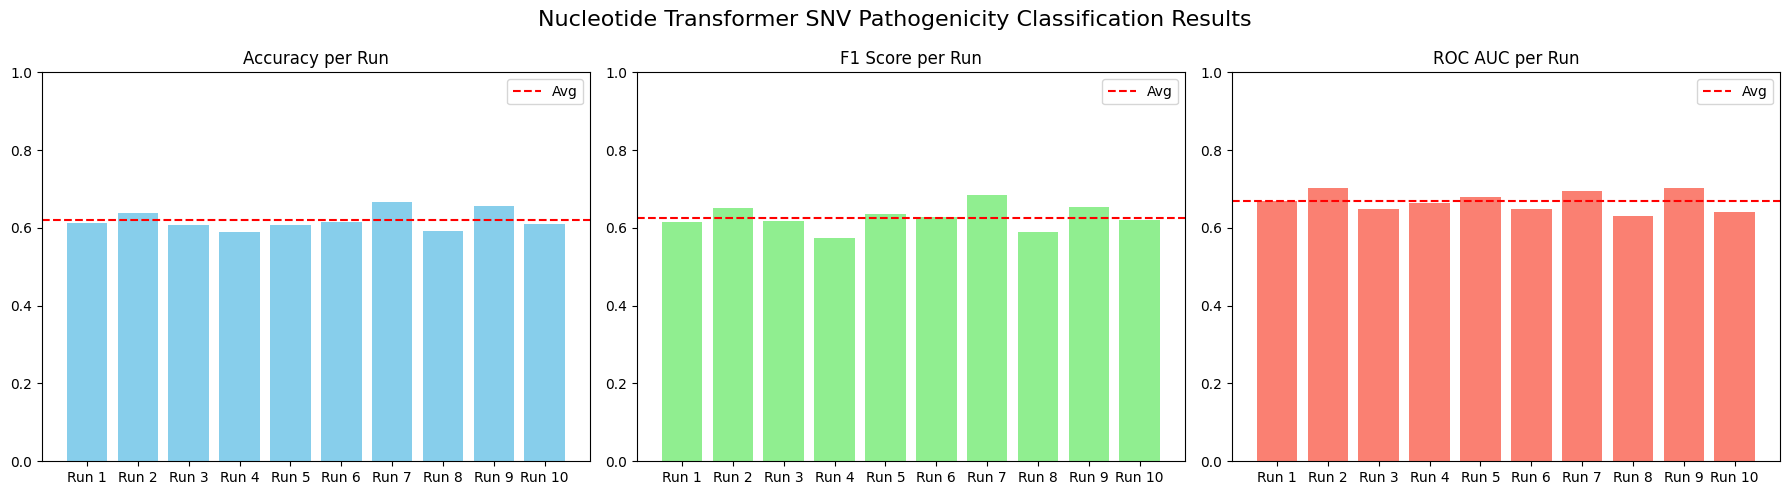

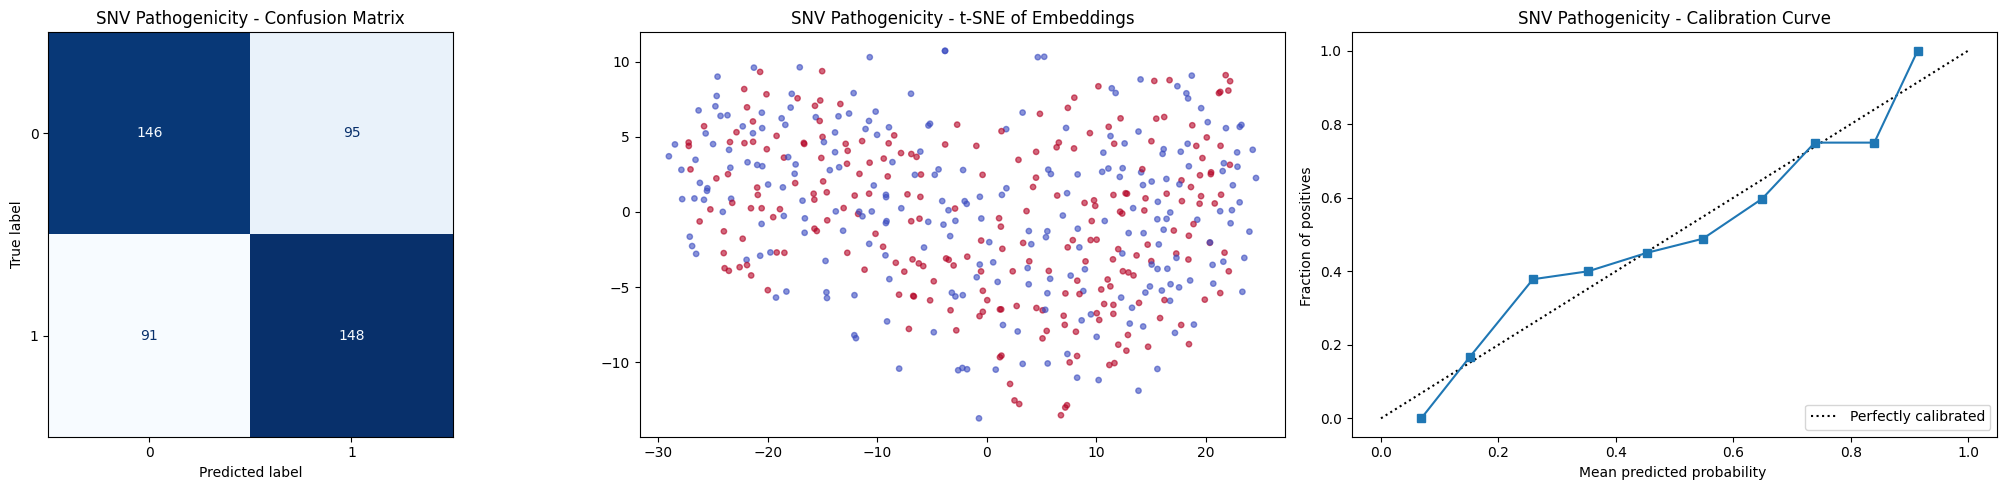

In [11]:
runs = [f"Run {i+1}" for i in range(10)]
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].bar(runs, accuracies_1, color='skyblue')
axs[0].axhline(y=np.mean(accuracies_1), color='red', linestyle='--', label='Avg')
axs[0].set_title('Accuracy per Run')
axs[0].set_ylim(0, 1)
axs[0].legend()

axs[1].bar(runs, f1_scores_1, color='lightgreen')
axs[1].axhline(y=np.mean(f1_scores_1), color='red', linestyle='--', label='Avg')
axs[1].set_title('F1 Score per Run')
axs[1].set_ylim(0, 1)
axs[1].legend()

axs[2].bar(runs, roc_aucs_1, color='salmon')
axs[2].axhline(y=np.mean(roc_aucs_1), color='red', linestyle='--', label='Avg')
axs[2].set_title('ROC AUC per Run')
axs[2].set_ylim(0, 1)
axs[2].legend()

fig.suptitle('Nucleotide Transformer SNV Pathogenicity Classification Results', fontsize=16)
plt.tight_layout()
plt.show()

# Confusion Matrix, t-SNE, Calibration (median accuracy)
median_idx = np.argsort(accuracies_1)[len(accuracies_1)//2]
y_t, y_p, y_pb, emb = run_outputs_1[median_idx]
plot_diagnostics(y_t, y_p, y_pb, emb, title_prefix="SNV Pathogenicity - ")

## Plot Results for Benchmark 3


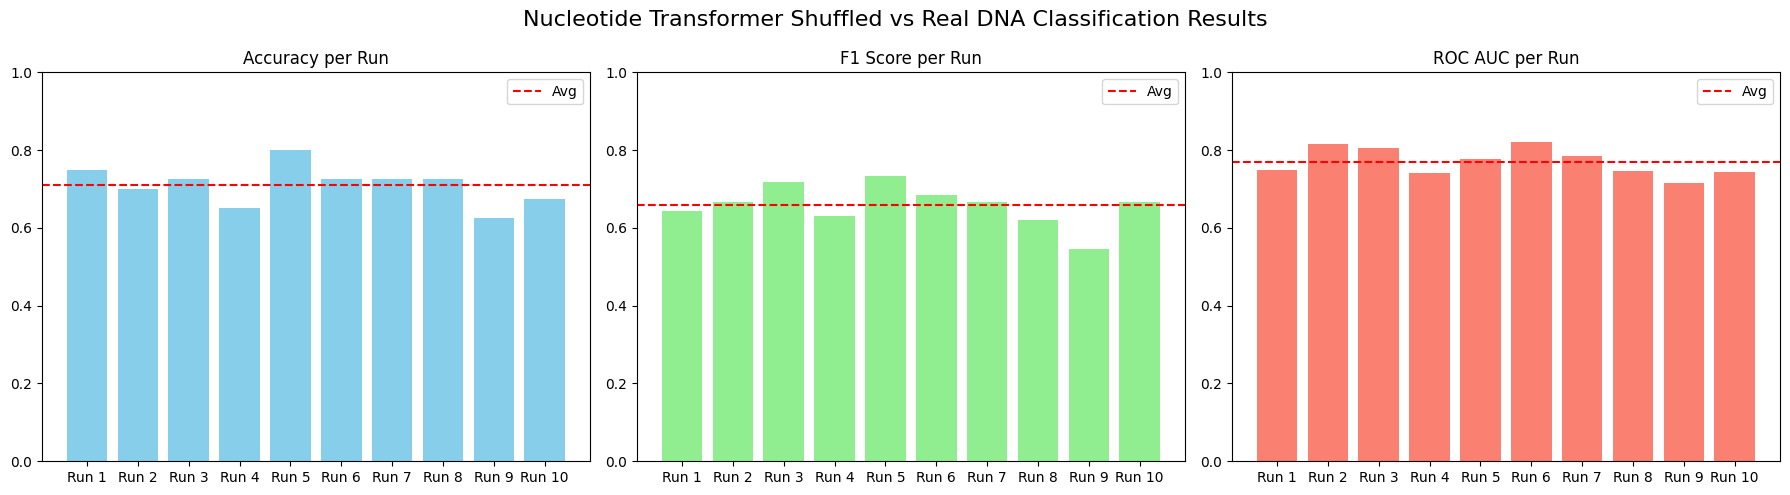

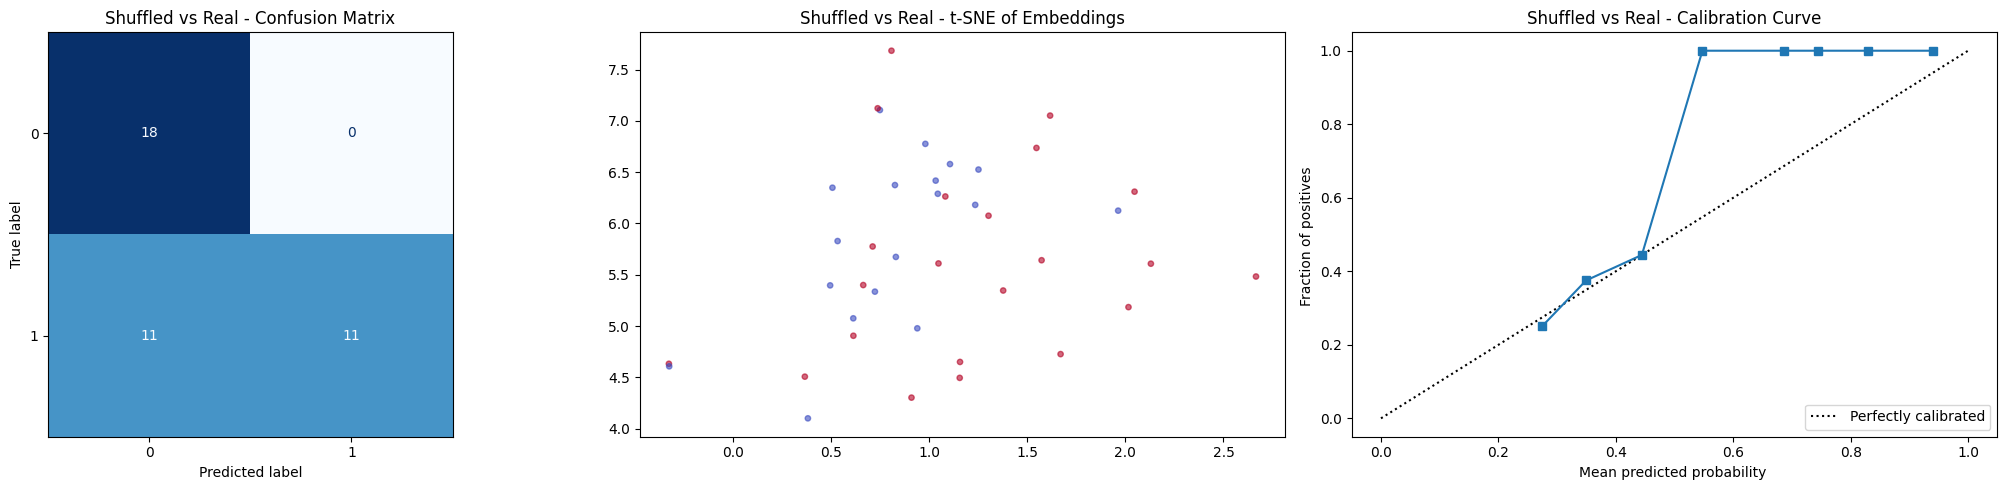

In [16]:
runs = [f"Run {i+1}" for i in range(10)]
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].bar(runs, accuracies_2, color='skyblue')
axs[0].axhline(y=np.mean(accuracies_2), color='red', linestyle='--', label='Avg')
axs[0].set_title('Accuracy per Run')
axs[0].set_ylim(0, 1)
axs[0].legend()

axs[1].bar(runs, f1_scores_2, color='lightgreen')
axs[1].axhline(y=np.mean(f1_scores_2), color='red', linestyle='--', label='Avg')
axs[1].set_title('F1 Score per Run')
axs[1].set_ylim(0, 1)
axs[1].legend()

axs[2].bar(runs, roc_aucs_2, color='salmon')
axs[2].axhline(y=np.mean(roc_aucs_2), color='red', linestyle='--', label='Avg')
axs[2].set_title('ROC AUC per Run')
axs[2].set_ylim(0, 1)
axs[2].legend()

fig.suptitle('Nucleotide Transformer Shuffled vs Real DNA Classification Results', fontsize=16)
plt.tight_layout()
plt.show()

median_idx = np.argsort(accuracies_2)[len(accuracies_2)//2]
y_t, y_p, y_pb, emb = run_outputs_2[median_idx]
plot_diagnostics(y_t, y_p, y_pb, emb, title_prefix="Shuffled vs Real - ")

## Plot Results for Benchmark 2


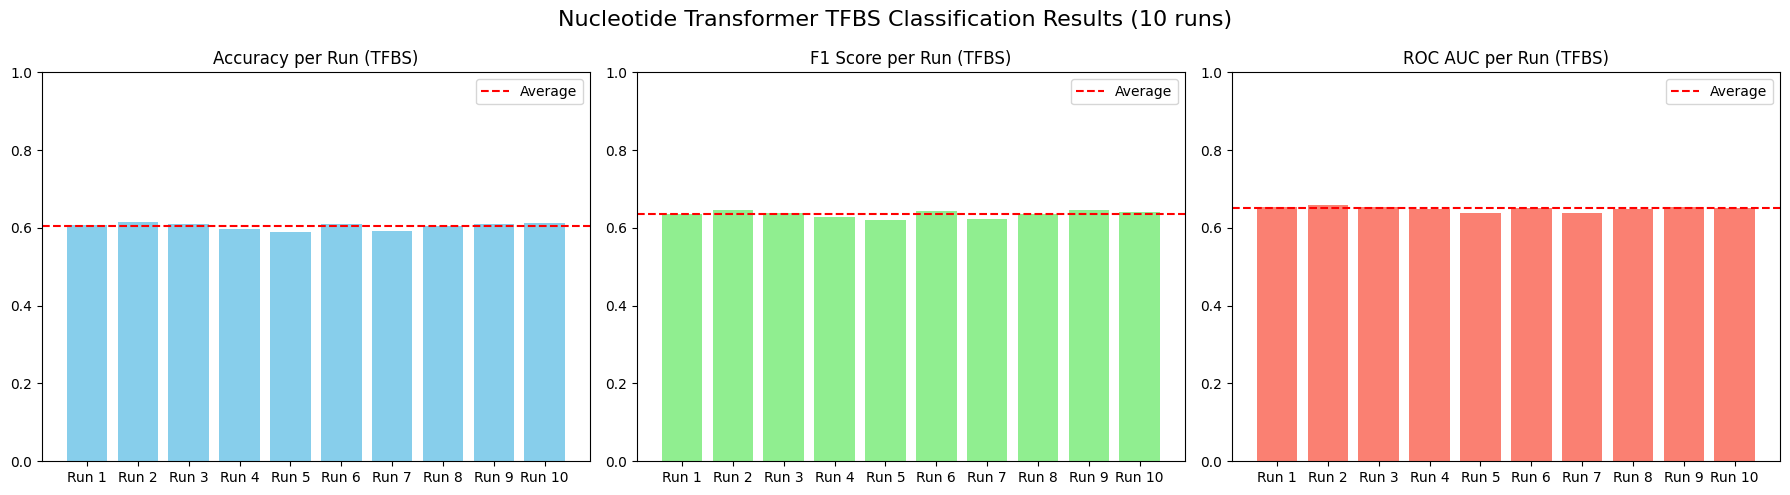

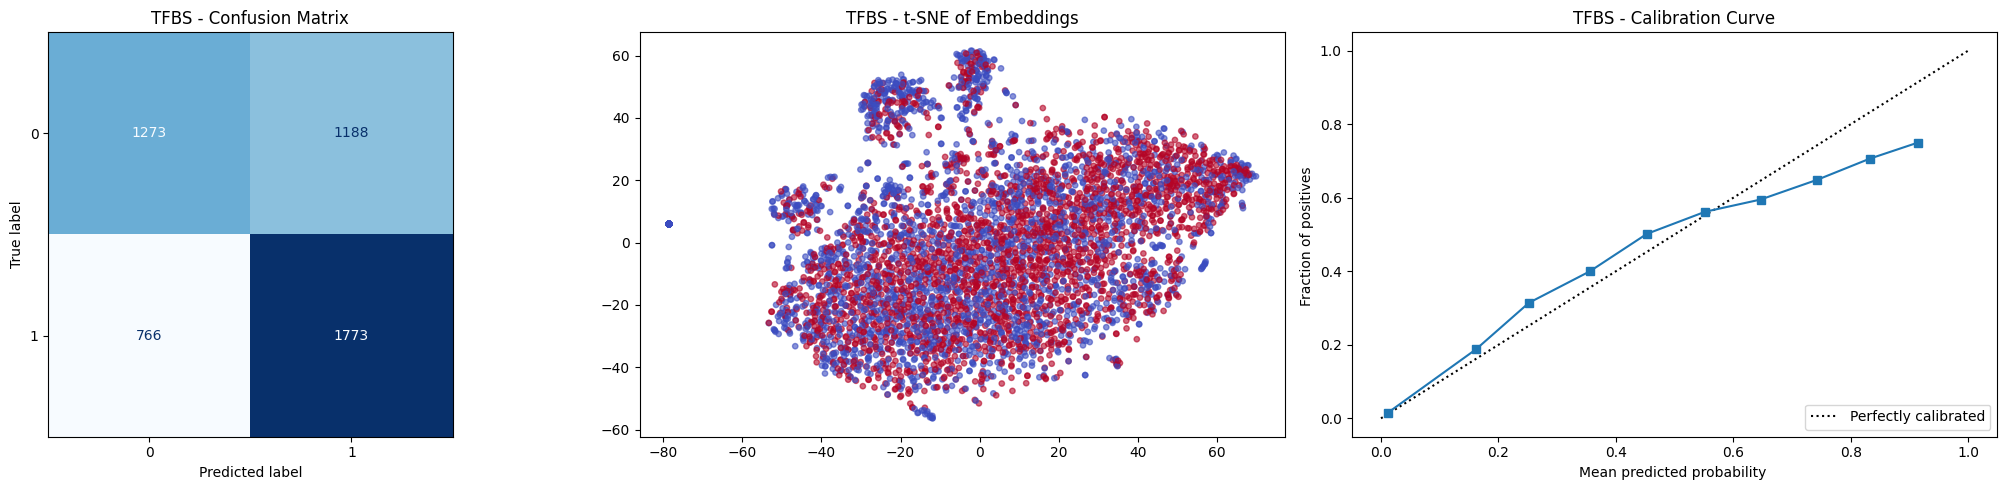

In [19]:
runs = [f"Run {i+1}" for i in range(10)]
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].bar(runs, accuracies_3, color='skyblue')
axs[0].axhline(y=np.mean(accuracies_3), color='red', linestyle='--', label='Average')
axs[0].set_title('Accuracy per Run (TFBS)')
axs[0].set_ylim(0, 1)
axs[0].legend()

axs[1].bar(runs, f1_scores_3, color='lightgreen')
axs[1].axhline(y=np.mean(f1_scores_3), color='red', linestyle='--', label='Average')
axs[1].set_title('F1 Score per Run (TFBS)')
axs[1].set_ylim(0, 1)
axs[1].legend()

axs[2].bar(runs, roc_aucs_3, color='salmon')
axs[2].axhline(y=np.mean(roc_aucs_3), color='red', linestyle='--', label='Average')
axs[2].set_title('ROC AUC per Run (TFBS)')
axs[2].set_ylim(0, 1)
axs[2].legend()

fig.suptitle('Nucleotide Transformer TFBS Classification Results (10 runs)', fontsize=16)
plt.tight_layout()
plt.show()

median_idx = np.argsort(accuracies_3)[len(accuracies_3)//2]
y_t, y_p, y_pb, emb = run_outputs_3[median_idx]
plot_diagnostics(y_t, y_p, y_pb, emb, title_prefix="TFBS - ")